<a href="https://colab.research.google.com/github/Pratham2012/Python-for-Finance/blob/main/Python_for_Finance_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
# We add .NS at the end as these companies are listed on the NSE(National Stock Exchange)
companies = ['RELIANCE.NS','TCS.NS','HDFCBANK.NS']

#Date range
start = '2018-01-01'
end = '2022-11-1'

data = yf.download(companies,start=start,end=end)['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [ ]:
#pct_change() is a built-in method in DataFrame that computes the percent change from one row to another which is exactly what a return is
returns = data.pct_change()
returns = returns.dropna()

In [ ]:
def semideviation(r):
    """
    Returns the semideviation of r.
    r must be a Series or a DataFrame, else it raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [ ]:
semideviation(returns)

HDFCBANK.NS    0.012213
RELIANCE.NS    0.013741
TCS.NS         0.011750
dtype: float64

In [ ]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")  

In [ ]:
var_historic(returns,level=1)

HDFCBANK.NS    0.038490
RELIANCE.NS    0.044791
TCS.NS         0.045349
dtype: float64

In [ ]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [ ]:
cvar_historic(returns,level=1)

HDFCBANK.NS    0.068231
RELIANCE.NS    0.077000
TCS.NS         0.060585
dtype: float64

In [ ]:
from scipy.stats import norm, skew, kurtosis

In [ ]:
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

In [ ]:
var_gaussian(returns)

HDFCBANK.NS    0.027489
RELIANCE.NS    0.032142
TCS.NS         0.026317
dtype: float64

In [ ]:
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skew(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [ ]:
var_gaussian(returns)

HDFCBANK.NS    0.027489
RELIANCE.NS    0.032142
TCS.NS         0.026317
dtype: float64

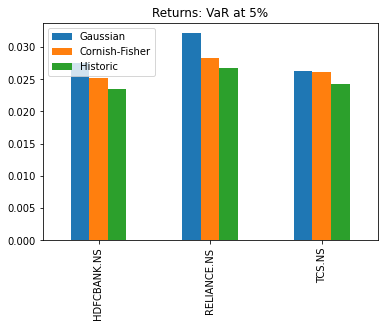

In [ ]:
var_table = [var_gaussian(returns), 
             var_gaussian(returns, modified=True), 
             var_historic(returns)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Returns: VaR at 5%")